In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import keras
keras.__version__

'2.4.3'

In [3]:
import tensorflow
tensorflow.__version__

'2.3.0'

In [4]:
# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials

In [5]:
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)

In [6]:
#1ybMB62yiqWTJWf224HKvm7nPRifnSG8D?usp=sharing
# one approach to get data is zip directory, and then unzip on this virtual machine
#downloaded = drive.CreateFile({'id':"1ykRetxLnjCi_wSY-LxTy03dG-TB1Shii"})
# https://drive.google.com/drive/folders/1ykRetxLnjCi_wSY-LxTy03dG-TB1Shii?usp=sharing
# unzip file on virtual machine..
# directory = downloaded

In [7]:
# downloaded.GetContentFile('satimg_AZ_18_Established Campground_17_31.703691999999997_-111.063476_rot90.png')

In [8]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Wed Aug 26 21:17:00 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [9]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.4 gigabytes of available RAM

You are using a high-RAM runtime!


In [10]:
#('TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)', 'TensorSpec(shape=(None,), dtype=tf.int32, name=None)')
from tensorflow import TensorSpec, float32, int32
from tensorflow import keras, data
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.data.experimental import load
elem_spec = (TensorSpec(shape=(None, 256, 256, 3), dtype=float32, name=None), TensorSpec(shape=(None,), dtype=int32, name=None))

In [11]:
# try to load tensorflow datasets from google drive into this notebook
# path to files:
# X_train_data_loaded = drive.CreateFile({'id':""})
# X_test_data_loaded = drive.CreateFile({'id':""})

X_train_data_path = '/content/drive/My Drive/TF_datasets/X_train'
X_test_data_path = '/content/drive/My Drive/TF_datasets/X_test'
X_train = load(X_train_data_path, element_spec=elem_spec, compression='GZIP', reader_func=None)
X_test = load(X_test_data_path, element_spec=elem_spec, compression='GZIP', reader_func=None)

In [12]:
num_classes = 2
epochs = 200 # number of passes through the entire train dataset before weights "final"
AUTOTUNE = data.experimental.AUTOTUNE
img_height = 256
img_width = 256
nb_filters = 32    # number of convolutional filters to use (same as neurons) if more, more parameters
pool_size = (2, 2)  # pooling decreases image size, reduces computation, adds translational invariance
kernel_size = (2, 2)  # convolutional kernel size, slides over image to learn features
X_train = X_train.cache().shuffle(32).prefetch(buffer_size=AUTOTUNE) # include shuffle? set to 32? X_train.cache().shuffle(1000)
# Note: While large buffer_sizes shuffle more thoroughly, they can take a lot of memory, and significant time to fill. 
# Consider using Dataset.interleave across files if this becomes a problem.
X_test = X_test.cache().prefetch(buffer_size=AUTOTUNE)

In [13]:
model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(256, 256, 3)),
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
    layers.Conv2D(nb_filters, (kernel_size[0], kernel_size[1]), padding='same', activation='relu'), # was 16, 32, 64
    layers.MaxPooling2D(pool_size=pool_size),
    layers.Conv2D(nb_filters*2, (kernel_size[0], kernel_size[1]), padding='same', activation='relu'), # drop layers.. for initial testing
    layers.MaxPooling2D(pool_size=pool_size),
    layers.Conv2D(nb_filters*3, (kernel_size[0], kernel_size[1]), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=pool_size),
    layers.Conv2D(nb_filters*4, (kernel_size[0], kernel_size[1]), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=pool_size),
    # insert more layers?
    # insert callback?
    layers.Flatten(),
    layers.Dense(256, activation='relu'), # increase this?
    layers.Dropout(0.5),
    #layers.Dense(num_classes, activation='relu') # or sigmoid for binary? relu?
    layers.Dense(1, activation='sigmoid') # or sigmoid for binary? relu?
])

In [14]:
model.compile(optimizer='adam', # adadelta sgd
              loss=keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 256, 256, 3)       0         
_________________________________________________________________
random_flip (RandomFlip)     (None, 256, 256, 3)       0         
_________________________________________________________________
random_rotation (RandomRotat (None, 256, 256, 3)       0         
_________________________________________________________________
random_zoom (RandomZoom)     (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 32)      416       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      8

In [229]:
# 450 GPU
# history = model.fit(
#             X_train,
#             validation_data = X_test,
#             epochs = epochs,
#             #batch_size=batch_size,
#             verbose = 1
# )

In [230]:
# with autotune stuff enabled (slower GPU)
# history = model.fit(
#             X_train,
#             validation_data = X_test,
#             epochs = epochs,
#             #batch_size=batch_size,
#             verbose = 1
# )

In [ ]:
history = model.fit(
            X_train,
            validation_data = X_test,
            epochs = epochs,
            #batch_size=batch_size,
            verbose = 1
)

Epoch 1/200
215/406 [==============>...............] - ETA: 52s - loss: 0.6634 - accuracy: 0.6471

In [152]:
score = model.evaluate(X_test, verbose=1) 
print('Test score:', score[0])
print('Test accuracy:', score[1])

102/102 [==============================] - 1s 13ms/step - loss: 0.4088 - accuracy: 0.8484
Test score: 0.4087788462638855
Test accuracy: 0.8484288454055786


In [153]:
predictions = model.predict(X_test, verbose=1)

102/102 [==============================] - 1s 12ms/step


In [175]:
predictions_binary = model.predict_classes(X_test, verbose=1) 

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
102/102 [==============================] - 1s 12ms/step


In [178]:
predictions_binary

array([[1],
       [1],
       [0],
       ...,
       [1],
       [0],
       [1]], dtype=int32)

In [179]:
predictions_binary = (model.predict(X_test) > 0.5).astype("int32")

In [180]:
predictions_binary

array([[1],
       [1],
       [0],
       ...,
       [1],
       [0],
       [1]], dtype=int32)

In [154]:
predictions[1000:1100,:]

array([[9.0574282e-01],
       [8.2370842e-01],
       [5.9639007e-01],
       [3.4318689e-01],
       [9.1223556e-01],
       [2.0705903e-07],
       [9.9622065e-01],
       [4.9361706e-01],
       [6.7981685e-14],
       [9.3246955e-01],
       [1.7297639e-02],
       [9.5244491e-01],
       [7.8560758e-01],
       [9.9997020e-01],
       [9.9999785e-01],
       [9.6618849e-01],
       [9.9996531e-01],
       [9.9998164e-01],
       [9.8927569e-01],
       [6.2016773e-01],
       [1.1939559e-03],
       [1.5074013e-11],
       [7.7193087e-01],
       [8.9810878e-01],
       [8.2454342e-01],
       [9.4913918e-01],
       [9.9591124e-01],
       [2.4303979e-09],
       [6.3673401e-01],
       [7.0527874e-02],
       [5.4455364e-01],
       [9.9346739e-01],
       [5.0097013e-01],
       [9.8442692e-01],
       [9.9236542e-01],
       [9.9987352e-01],
       [7.6005584e-01],
       [3.2131806e-01],
       [9.4965088e-01],
       [9.8672605e-01],
       [9.8768103e-01],
       [9.862040

In [53]:
predictions_df = pd.DataFrame(predictions) # , columns=X_test.class_names)
predictions_df.describe()

,0
count,3246.000000
mean,0.706621
std,0.433733
min,0.000000
25%,0.084044
50%,0.999737
75%,1.000000
max,1.000000


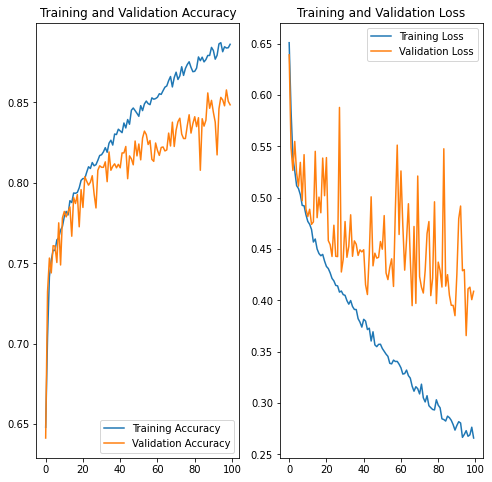

<Figure size 432x288 with 0 Axes>

In [155]:
# plot results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
plt.savefig('earlierrun.png')

In [156]:
y = np.concatenate([y for x, y in X_test], axis=0)

In [157]:
y.shape

(3246,)

In [158]:
y_pred = predictions.ravel()

In [167]:
y_pred.shape

(3246,)

In [168]:
y_pred[:10]

array([9.1557467e-01, 9.4814855e-01, 4.5636219e-01, 8.9590991e-01,
       9.9919027e-01, 9.5066565e-01, 9.6600002e-01, 4.0917976e-09,
       9.9803334e-01, 9.2713726e-01], dtype=float32)

In [169]:
y[:10]

array([1, 1, 1, 1, 1, 1, 1, 0, 1, 1], dtype=int32)

In [187]:
from sklearn import metrics
fpr_keras, tpr_keras, thresholds_keras = metrics.roc_curve(y, y_pred)
auc_keras = metrics.auc(fpr_keras, tpr_keras)

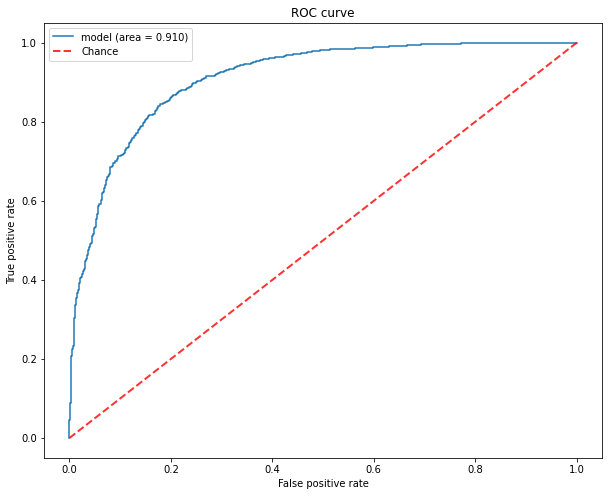

In [188]:
# https://www.dlology.com/blog/simple-guide-on-how-to-generate-roc-plot-for-keras-classifier/
fig, ax = plt.subplots(1, figsize=(10, 8))
ax.plot(fpr_keras, tpr_keras, label='model (area = {:.3f})'.format(auc_keras))
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')
ax.set_title('ROC curve')
plt.legend(loc='best')
plt.show()

In [192]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
def compute_plot_confusion_matrix(y_true_class, y_pred_class, classes):
    confmat = confusion_matrix(y_true_class, y_pred_class, labels=range(2))
    confmat = confmat / confmat.sum(0).astype(float)
    df_cm = pd.DataFrame(confmat, columns = classes)
    plt.figure(figsize = (12,10))
    sns.heatmap(df_cm, annot=True, fmt=".2f")
    return confmat

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [190]:
confmat = confusion_matrix(y, predictions_binary)

In [182]:
confmat

array([[ 739,  364],
       [ 128, 2015]])

In [194]:
confmat / confmat.sum(0).astype(float)

array([[0.85236448, 0.15300546],
       [0.14763552, 0.84699454]])

array([[0.85236448, 0.15300546],
       [0.14763552, 0.84699454]])

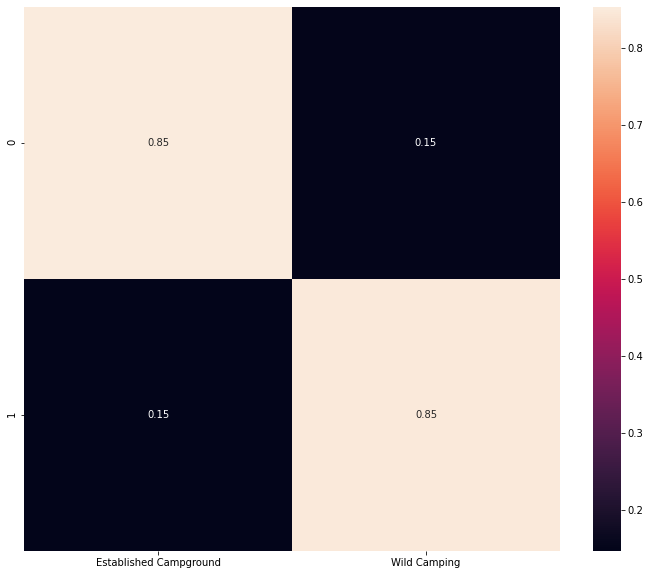

In [193]:
compute_plot_confusion_matrix(y, predictions_binary, ['Established Campground', 'Wild Camping'])

In [ ]:
# check some images where predictions were wrong
